## Assignment 2

Responding to recent news stories about how COVID has had a larger impact on underserved racial and socioeconomic groups, the New York City government has asked you to look at the correlation across zipcodes between Census demographics (income and race) and  COVID impacts (case, death, and positivity rates). Unfortunately, the data you have been given for this assignment is, like many real world datasets, very messy, so you will need to clean it with care. 


*Note: in this assignment, we artifically introduced errors into the data to help introduce concepts - this is not the original data provided by the New York government or by the Census Bureau. Please don't tweet angry things at the city government and get us fired :)*

*To make this assignment less frustrating for you, we have included sanity checks throughout to make sure you are on the right track. Please pay attention to these sanity checks! If you are not passing them, it is a sign something has gone wrong. In the real world, of course, you would not have these sanity checks, which is why data cleaning is hard and frustrating.*

#### A first challenge is even figuring out which columns you want. Read the codebook for Census data (you can find this in the data folder with the other data files)  to figure out which column provides the median income for each zipcode. Drop the rows with missing values (NA or None) in this column and change its name into "median_income". (5 points)

*Sanity check: you will have 30,824 rows in census data after this step.*

In [3]:
# import pandas
import pandas as pd

# load Census Data csv into dataframe
dfCensus = pd.read_csv ('./a2-data/messy_nhgis0004_ds244_20195_2019_zcta.csv')

# find median income via .txt file - ALW1E001  AND change name column to "medium_income"
dfCensus.rename(columns = {"ALW1E001": "median_income"}, inplace = True)

# drop NA or None values
dfCensus = dfCensus.dropna(subset=['median_income'])

# print shape size
dfCensus.shape

(30824, 82)

#### Use two of the columns in the Census data to compute the fraction of people who are white non-Hispanic in each zipcode. Add this column to the Census dataframe and call it "white_non_hispanic_frac". (5 points)
*Sanity check: the mean value of "white_non_hispanic" is around 0.764*

In [4]:
dfCensus['white_non_hispanic_frac'] = dfCensus["ALUKE003"] / dfCensus["ALUKE001"]  # calc fraction from non-hispanic white over total group

dfCensus["white_non_hispanic_frac"].mean() 

0.7641021559721349

Now we have to find keys to merge the Census dataset with the COVID dataset. Look for a key in the Census dataset which corresponds to a location grouping you can use to merge with the COVID data. Unfortunately, the closest thing you can find is ZCTA, and the only thing in the New York City COVID data is MODZCTA. Read this documentation, which explains the difference - https://github.com/nychealth/coronavirus-data#geography-zip-codes-and-zctas. Basically, multiple ZCTAs can map to a single MODZCTA. 

To address this problem, you need to modify the Census data by filtering for ZCTAs which appear in the MODZCTA table and merging the Census data with the MODZCTA table using pd.merge. Prior to doing this merge, be sure that any keys you expect to be be unique in the Census data (ie, different in every row) are really unique, as we discussed in class - drop duplicate rows if necessary!

#### After doing the merge, you will be left with a dataframe which has multiple rows for some MODZCTAs; combine rows which correspond to the same MODZCTA into a single row. Every time you combine multiple rows, combine the values for white_non_hispanic and median_income by taking the mean. You can do this using the pandas groupby and agg commands. (20 points)

*Sanity check: If you did this step correctly, you should be left with a Census table which contains 177 rows.*

In [5]:
# load MODZCTA Table Data csv into dataframe
dfModzcta = pd.read_csv ('./a2-data/messy_ZCTA-to-MODZCTA.csv')

# drop duplicates and drop nan values in columns
dfModzcta = dfModzcta.drop_duplicates(subset=['ZCTA'])
dfCensus = dfCensus.drop_duplicates()

# drop duplications, merge the modzcta table on keys 'zcta5a' and 'zcta', grouping by 'modzcta' and aggregate by taking taking the mean 
dfCensusMerged = dfCensus.merge(dfModzcta, left_on='ZCTA5A', right_on='ZCTA').groupby("MODZCTA").agg({'white_non_hispanic_frac': 'mean', 'median_income': 'mean'})

# reset index
dfCensusMerged.reset_index(inplace=True)

dfCensusMerged.describe()

,white_non_hispanic_frac,median_income
count,177.000000,177.000000
mean,0.363369,77805.544256
std,0.257827,38102.910089
min,0.010038,21447.000000
25%,0.118419,54184.000000
50%,0.355179,70793.000000
75%,0.587448,93364.333333
max,0.910724,250001.000000


#### Now we have a Census data table we can merge with the NYC COVID data. Merge the two datasets using MODZCTA as the merge key. As we discussed in class, you may need to write some extra code to make sure that the keys in the two different tables are in the exact same format (for example, if one is an integer, the other should be an integer as well, or the merge will not work) (5 points) ####

In [6]:
# import covid dataset
dfCovid = pd.read_csv ('./a2-data/messy_covid_data.csv')

# convert columns to integers
dfCensusMerged['MODZCTA'] = dfCensusMerged.MODZCTA.str[1:].astype('int64')

# merge datasets
dfCovidCensusMerged = dfCensusMerged.merge(dfCovid, left_on='MODZCTA', right_on='MODIFIED_ZCTA')

# print results
dfCovidCensusMerged.describe()

,MODZCTA,white_non_hispanic_frac,median_income,MODIFIED_ZCTA,lat,lon,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,10810.378531,0.363369,77805.544256,10810.378531,40.725552,-73.918805,4269.734463,-36834.250395,47100.661356,156.903955,313.450395,12.769492,31836.949153
std,578.173317,0.257827,38102.910089,578.173317,0.083648,0.099659,2780.595978,210166.276084,26151.569294,117.267598,145.522976,4.880957,17220.295085
min,10001.000000,0.010038,21447.000000,10001.000000,40.507771,-74.242270,168.000000,-999999.000000,2972.120000,0.000000,0.000000,0.000000,2691.000000
25%,10301.000000,0.118419,54184.000000,10301.000000,40.670819,-73.978704,2030.000000,6317.060000,27180.770000,64.000000,225.010000,8.840000,18582.000000
50%,11109.000000,0.355179,70793.000000,11109.000000,40.726441,-73.924048,3565.000000,8704.640000,42737.280000,124.000000,310.900000,14.150000,29383.000000
75%,11361.000000,0.587448,93364.333333,11361.000000,40.776432,-73.846984,6107.000000,10619.150000,66856.310000,229.000000,388.220000,16.260000,44749.000000
max,11697.000000,0.910724,250001.000000,11697.000000,40.899509,-73.710907,11985.000000,16830.670000,110369.780000,540.000000,944.530000,20.400000,78120.000000


#### Now compute the correlations across MODZCTAs between the white non-Hispanic fraction, the median income, and the COVID case and death rates and percent positive. If you want to compute correlations between all five of these variables at once, you can use the pandas method "corr".  (5 points) #### 

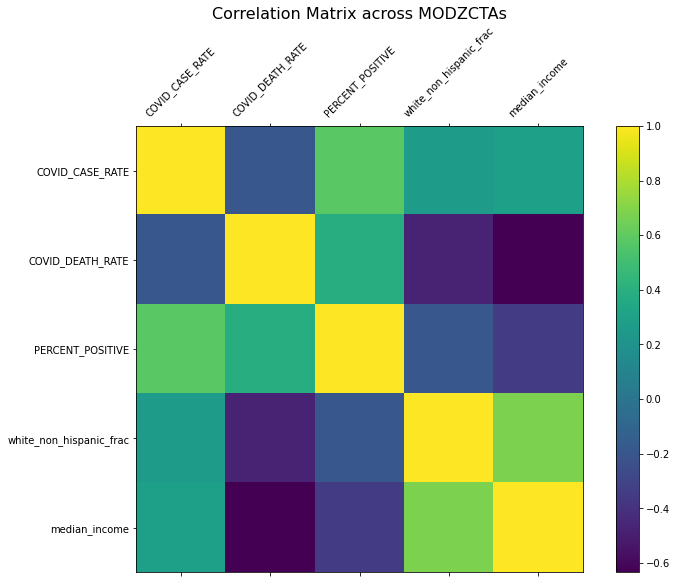

                         COVID_CASE_RATE  COVID_DEATH_RATE  PERCENT_POSITIVE  \
COVID_CASE_RATE                 1.000000         -0.188458          0.579739   
COVID_DEATH_RATE               -0.188458          1.000000          0.386285   
PERCENT_POSITIVE                0.579739          0.386285          1.000000   
white_non_hispanic_frac         0.267831         -0.469271         -0.192959   
median_income                   0.286642         -0.634857         -0.346742   

                         white_non_hispanic_frac  median_income  
COVID_CASE_RATE                         0.267831       0.286642  
COVID_DEATH_RATE                       -0.469271      -0.634857  
PERCENT_POSITIVE                       -0.192959      -0.346742  
white_non_hispanic_frac                 1.000000       0.676294  
median_income                           0.676294       1.000000  


In [7]:
import matplotlib.pyplot as plt

correlationColumns = [
    "COVID_CASE_RATE",
    "COVID_DEATH_RATE",
    "PERCENT_POSITIVE",
    "white_non_hispanic_frac",
    "median_income"
]

# selected and group data by modzcta
dfSelected = dfCovidCensusMerged.groupby(by='MODZCTA').mean() # get mean across modzctas
dfGrouped = dfSelected.filter(correlationColumns, axis=1)

# plot a correlation matrix graph 
# source: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

f = plt.figure(figsize=(12, 8))
plt.matshow(dfGrouped.corr(), fignum=f.number)
plt.xticks(range(dfGrouped.select_dtypes(['number']).shape[1]), dfGrouped.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(dfGrouped.select_dtypes(['number']).shape[1]), dfGrouped.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix across MODZCTAs', fontsize=16)


plt.show()

print(dfGrouped.corr())


#### Are the correlations in the directions you expect? Write a couple sentences interpreting the direction of the correlations. (5 points) #### 

First of all, there are a The Median Income highly correlates with the white non hispanic fraction, but not with the death rate. Within this race group, the death rates is most significant apart and therefor correlates less. Moreover, COVID Death Rates correlates most to the percentage of positive in the tested group, which is in the line of expectations. It seems that the case rate is not very impactful on the death rate, which is interesting. 

This is the first time analyzing a correlation matrix, therefor I had no other prior assumptions. Besides, I found it insightful that the printed table created more value for the reader that the graph. This is mostly because the level of detail and amount of variables can't create a significante gradient pattern.


#### It turns out that several of these five columns have bad values that we still haven't filtered out. Use the pandas method "describe" to find values which are implausibly large or small. Print out the results here and explain your interpretation. (10 points) ####

In [8]:
dfGrouped.describe()

,COVID_CASE_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,white_non_hispanic_frac,median_income
count,177.000000,177.000000,177.000000,177.000000,177.000000
mean,-36834.250395,313.450395,12.769492,0.363369,77805.544256
std,210166.276084,145.522976,4.880957,0.257827,38102.910089
min,-999999.000000,0.000000,0.000000,0.010038,21447.000000
25%,6317.060000,225.010000,8.840000,0.118419,54184.000000
50%,8704.640000,310.900000,14.150000,0.355179,70793.000000
75%,10619.150000,388.220000,16.260000,0.587448,93364.333333
max,16830.670000,944.530000,20.400000,0.910724,250001.000000


First of all, in the COVID_CASE RATE there is a mean that is below zero. Moreover, the number -999999 indicates that there might be substitute numbers used in case of missing data. Secondly, the max COVID_DEATH_RATE seems unlikly since it is very far apart from the top 75% and the mean. Same goes for the max in median_income where the highest number is almost 2.5 times as much as the top 75%. To solve this, I would analyse the COVID_CASE_RATE min, the COVID_DEATH_RATE max and the median_income max to find the outliers.

#### Recompute these correlations after removing the rows with these bad values (a tip: look at the abnormal values in covid data). How many rows did you remove? (10 points) ####

In [9]:
from scipy import stats
import numpy as np

# Calculate zindex for dataset and calc absolute value to remove outliers
# source: https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python
dfCleaned = dfGrouped[(np.abs(stats.zscore(dfGrouped)) < 3).all(axis=1)]

# 18 total remove rows 
print("\n \n Before cleaning")
print(dfGrouped.corr())

print("\n \n After cleaning")
print(dfCleaned.corr())



 
 Before cleaning
                         COVID_CASE_RATE  COVID_DEATH_RATE  PERCENT_POSITIVE  \
COVID_CASE_RATE                 1.000000         -0.188458          0.579739   
COVID_DEATH_RATE               -0.188458          1.000000          0.386285   
PERCENT_POSITIVE                0.579739          0.386285          1.000000   
white_non_hispanic_frac         0.267831         -0.469271         -0.192959   
median_income                   0.286642         -0.634857         -0.346742   

                         white_non_hispanic_frac  median_income  
COVID_CASE_RATE                         0.267831       0.286642  
COVID_DEATH_RATE                       -0.469271      -0.634857  
PERCENT_POSITIVE                       -0.192959      -0.346742  
white_non_hispanic_frac                 1.000000       0.676294  
median_income                           0.676294       1.000000  

 
 After cleaning
                         COVID_CASE_RATE  COVID_DEATH_RATE  PERCENT_POSITIVE  \
COVI

*If you're doing it correctly, you may have the correlation between median_income and COVID_CASE_RATE as around -0.54766, rather than the positive value you got before (0.286642). This is why it's important to be careful cleaning your data - if you get unlucky, a couple bad datapoints can totally change your conclusions.*

Another important lesson here is to use statistical measures which are robust (ie, won't totally break) if you have a few bad datapoints. Conventional correlation (Pearson correlation) can be heavily influenced by outliers, which is why it breaks here. Spearman correlation is less influenced by outliers, for reasons we'll discuss. Compute Spearman correlation using the messy data, without filtering out the bad rows; you will see that it is less sensitive to outliers.

#### Another way to make your analyses robust is to run them several different ways: for example, compute both Spearman AND pearson correlation. This is a good idea in general. (5 points) ####

In [10]:
print("Spearman Correlation")
print(dfCleaned.corr(method ='spearman'))
print("\n \n Pearson Correlation")
print(dfCleaned.corr(method ='pearson'))


Spearman Correlation
                         COVID_CASE_RATE  COVID_DEATH_RATE  PERCENT_POSITIVE  \
COVID_CASE_RATE                 1.000000          0.620466          0.944258   
COVID_DEATH_RATE                0.620466          1.000000          0.591607   
PERCENT_POSITIVE                0.944258          0.591607          1.000000   
white_non_hispanic_frac        -0.325886         -0.528128         -0.385725   
median_income                  -0.487241         -0.599818         -0.476974   

                         white_non_hispanic_frac  median_income  
COVID_CASE_RATE                        -0.325886      -0.487241  
COVID_DEATH_RATE                       -0.528128      -0.599818  
PERCENT_POSITIVE                       -0.385725      -0.476974  
white_non_hispanic_frac                 1.000000       0.690717  
median_income                           0.690717       1.000000  

 
 Pearson Correlation
                         COVID_CASE_RATE  COVID_DEATH_RATE  PERCENT_POSITIVE  

#### It's also a good idea to plot the data. Use seaborn's pairplot function to plot all 5 variables, making it obvious that something weird is happening with the original values. (5 points) ####

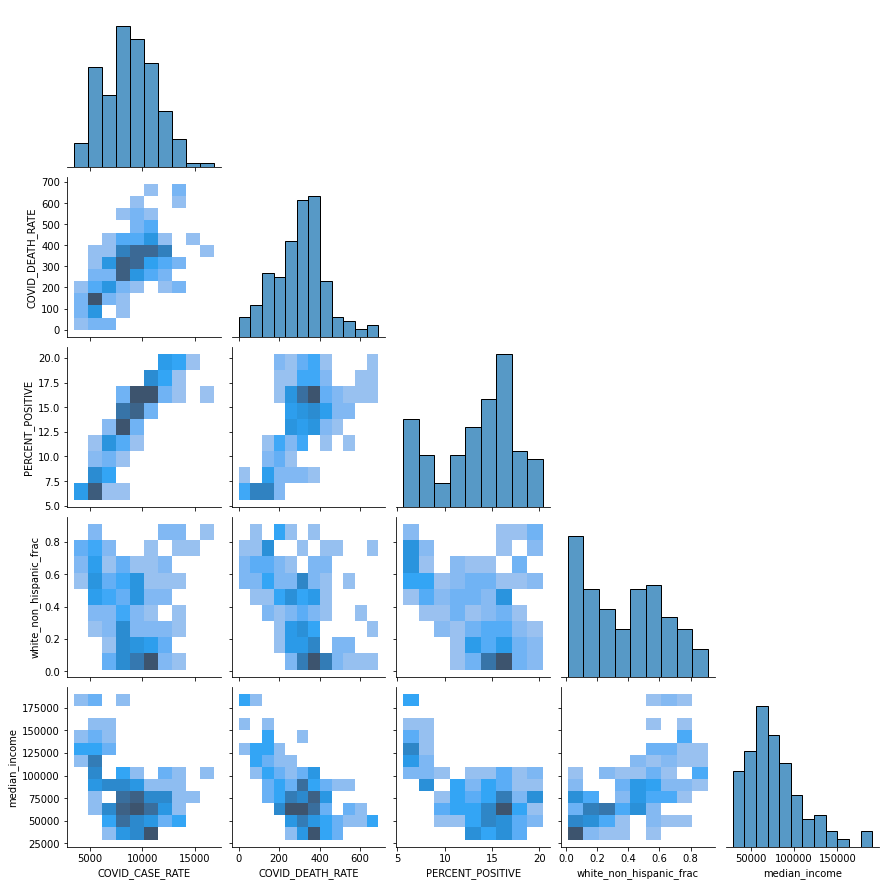

In [11]:
# import seaborn
import seaborn as sns

# make pairplot
sns.pairplot(dfCleaned, kind='hist', corner=True)

#### Using the same merged dataframe you just used, re-calculate the Spearman correlation with same five variables (white non-Hispanic fraction, median income, COVID_CASE_RATE, COVID_DEATH_RATE, and PERCENT_POSITIVE). But this time, use the NEIGHBORHOOD_NAME as a location grouping rather than MODZCTA, as described below (25 points):

1. Split up neighborhoods using the "/" character. For example, "Chinatown" is one neighborhood. And MODZCTAs with the “Chinatown/Lower East Side” label should go into both the Chinatown row and the Lower East Side row.
2. Use the mean of all rate/percentage values of a certain neighborhood as its variable. For example, if "Roosevelt Island" has two MODZCTAs "Roosevelt Island/Lenox Hill" and "Roosevelt Island/Midtown East" and these two areas have PERCENT_POSITIVE as 12.00 and 8.00 respectively, then we assume Roosevelt Island has PERCENT_POSITIVE as (12+8)/2=10.00. Similarly, if the median income in "Roosevelt Island/Lenox Hill" is 1000, and the median income in "Roosevelt Island/Midtown East" is 2200, then we assume that Roosevelt Island has a median income of (2200 + 1000) / 2 = 1600. 
3. Remove all rows with abnormal COVID data prior to performing this analysis. 

What do you find?

*Sanity check 1: You should find 225 unique neighborhoods before removing rows with abnormal values*

*Sanity check 2: The mean of median_income in "Financial District" is around $164000 (and you may drop one zipcode row of Financial District due to the lack of data).*

In [12]:
# set all columns to string, replace whitespaces and split at /
dfCovidCensusMerged['NEIGHBORHOOD_NAME'] = dfCovidCensusMerged['NEIGHBORHOOD_NAME'].astype(str)
dfCovidCensusMerged['NEIGHBORHOOD_NAME'] = dfCovidCensusMerged.NEIGHBORHOOD_NAME.str.replace(" ", "")
dfCovidCensusMerged['NEIGHBORHOOD_NAME'] = dfCovidCensusMerged.NEIGHBORHOOD_NAME.str.split("/")

# ;oop over all neighbourhoods, put them in new object, find unique neighborhood → append as a new row via Function (2)

totalNeighborhoods = []

for val in dfCovidCensusMerged.NEIGHBORHOOD_NAME:
    totalNeighborhoods += val

# sanity check 1: length of total elements in array to check if its working // 225
print(len(set(totalNeighborhoods)))

# transform each element to a row in dataframe with .explode
dfExploded = dfCovidCensusMerged.explode(column='NEIGHBORHOOD_NAME')

# created new df with above results and grouped by earlier correlation columns, get mean and reset index
dfNeighborhoods = dfExploded.groupby('NEIGHBORHOOD_NAME')[correlationColumns].mean().reset_index()

# sanity check 2: on median income in financial district // 163667.75
print(dfNeighborhoods[dfNeighborhoods.NEIGHBORHOOD_NAME == "FinancialDistrict"].median_income)

# get correlation in neighbours covid cases with spearman and round result
dfNeighborhoods[dfNeighborhoods.COVID_CASE_RATE >= 0].corr(method='spearman').round(2)

# find absolute differences in correlation in datasets
abs(dfNeighborhoods[dfNeighborhoods.COVID_CASE_RATE >= 0].corr(method='spearman').round(2) - dfCovidCensusMerged[correlationColumns].corr(method='spearman').round(2))

# print results
print(dfNeighborhoods.median_income.max(), dfCovidCensusMerged.median_income.max())


225
74    163667.75
Name: median_income, dtype: float64
216380.5 250001.0
